In [2]:
#라이브러리 로드
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os
import random
import matplotlib.pyplot as plt
import shutil
import seaborn as sns

from keras.preprocessing.image import load_img 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
from numpy import dot
from numpy.linalg import norm

## 0. 상숫값 및 경로 설정

In [80]:
data_20_dir = 'saves_yuv_20/' #1.데이터 불러오기 - csv 데이터 폴더 디렉토리
data_30_dir = 'saves_yuv_30/'
image_dir = "images/" #5.이미지 로드 및 그룹화 - 이미지 폴더 디렉토리
result_20_dir = "recommand_20/" #7. 데이터 저장 - 데이터 저장 디렉토리
result_30_dir = "recommand_30/"
pca_threshold = 0.99 #3. PCA - 적합한 차원 수 찾기

## 1. 데이터 불러오기¶

In [ ]:
# this list holds all the image filename
file_names = []
data_20 = []

with os.scandir(data_20_dir) as files:
    for file in files:
        # 모든 csv 파일 읽어오기
        if file.name.endswith('csv'):
            file_names.append(data_20_dir + file.name)
            
for file in file_names:
    now = pd.read_csv(file, header = 0, index_col = 0).to_numpy()
    data_20.append(now)

In [6]:
# this list holds all the image filename
file_names = []
data_30 = []

with os.scandir(data_30_dir) as files:
    for file in files:
        # 모든 csv 파일 읽어오기
        if file.name.endswith('csv'):
            file_names.append(data_30_dir + file.name)
            
for file in file_names:
    now = pd.read_csv(file, header = 0, index_col = 0).to_numpy()
    data_30.append(now)

In [85]:
image_file_names = []

for file in file_names:
    image_file_names.append(image_dir + file.rsplit('.')[0].rsplit('/')[1] + '.jpg')

## 2. RGB 스케일 평준화 작업, 유사도 비교

In [67]:
def flatten_with_rgb(data, div, scale):
    flt_data = []
    for feature in data: 
        r = (feature[:,0] / div).astype(int)
        g = (feature[:,1] / div).astype(int)
        b = (feature[:,2] / div).astype(int)
        tar = g * scale * scale + r * scale + b
        
        new_row = np.zeros(scale**3)
        for num, val in zip(tar, data[0][:, 6]):
            new_row[num] += val #+ (0.01 * num)
            
        flt_data.append(new_row)
    return flt_data

In [68]:
# 코사인 유사도 함수 
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

### 2-1. 8x8x8 Scale

<AxesSubplot:ylabel='Count'>

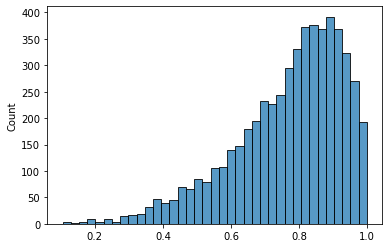

In [69]:
flt_data_20 = flatten_with_rgb(data_20, 0.125001, 8)
flt_data_30 = flatten_with_rgb(data_30, 0.125001, 8)

sim_8 = []
for d20, d30, file in zip(flt_data_20, flt_data_30, file_names):
    sim_8.append(cos_sim(d20, d30))
sns.histplot(sim_8)

### 2-2. 10x10x10 Scale

<AxesSubplot:ylabel='Count'>

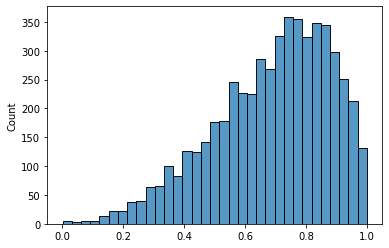

In [70]:
flt_data_20 = flatten_with_rgb(data_20, 0.100001, 10)
flt_data_30 = flatten_with_rgb(data_30, 0.100001, 10)

sim_10 = []
for d20, d30, file in zip(flt_data_20, flt_data_30, file_names):
    sim_10.append(cos_sim(d20, d30))
sns.histplot(sim_10)

### 2-3. 5x5x5 Scale

<AxesSubplot:ylabel='Count'>

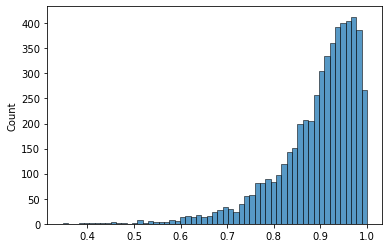

In [73]:
flt_data_20 = flatten_with_rgb(data_20, 0.200001, 5)
flt_data_30 = flatten_with_rgb(data_30, 0.200001, 5)

sim_5 = []
for d20, d30, file in zip(flt_data_20, flt_data_30, file_names):
    sim_5.append(cos_sim(d20, d30))
sns.histplot(sim_5)

### 2-4. 4x4x4 Scale

<AxesSubplot:ylabel='Count'>

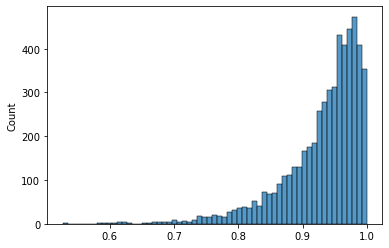

In [76]:
flt_data_20 = flatten_with_rgb(data_20, 0.250001, 4)
flt_data_30 = flatten_with_rgb(data_30, 0.250001, 4)

sim_4 = []
for d20, d30, file in zip(flt_data_20, flt_data_30, file_names):
    sim_4.append(cos_sim(d20, d30))
sns.histplot(sim_4)

<AxesSubplot:ylabel='Count'>

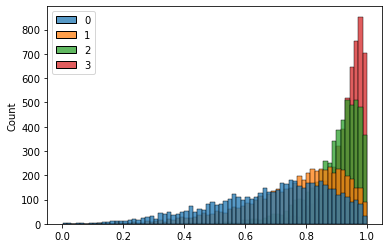

In [79]:
sns.histplot([sim_10, sim_8, sim_5, sim_4])

In [81]:
flt_data_20 = flatten_with_rgb(data_20, 0.250001, 4)
flt_data_30 = flatten_with_rgb(data_30, 0.250001, 4)

In [82]:
def pca_test(data, threshold):
    pca = PCA(n_components = len(data[0]), random_state = 2021)
    pca.fit_transform(data)
    
    ratio = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(ratio >= threshold) + 1    
    return (d, ratio[d - 1])

In [84]:
def clustering_data(data, target_cluster = 50):
    kmeans = KMeans(n_clusters=target_cluster, random_state=22)
    return kmeans.fit(data)

In [86]:
def grouping_by_clusters(image_file_names, labels):
    groups = {}
    for file, cluster in zip(image_file_names, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [87]:
pca_component_20 = pca_test(flt_data_20, pca_threshold)
pca = PCA(n_components = pca_component_20[0], random_state = 2021)
pca_data_20 = pca.fit_transform(flt_data_20)
clu_data_20 = clustering_data(pca_data_20)
groups_20 = grouping_by_clusters(image_file_names, clu_data_20.labels_)

In [88]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        
def save_data(groups, result_dir):
    for clusters, files in groups.items():
        createFolder(result_dir + str(clusters))
        for file in files:
            shutil.copyfile(file, result_dir + str(clusters) + '/' + file.rsplit('/')[1])

In [89]:
save_data(groups_20, result_20_dir)

In [90]:
pca_component_30 = pca_test(flt_data_30, pca_threshold)
pca = PCA(n_components = pca_component_30[0], random_state = 2021)
pca_data_30 = pca.fit_transform(flt_data_30)
clu_data_30 = clustering_data(pca_data_30)
groups_30 = grouping_by_clusters(image_file_names, clu_data_30.labels_)
save_data(groups_30, result_30_dir)